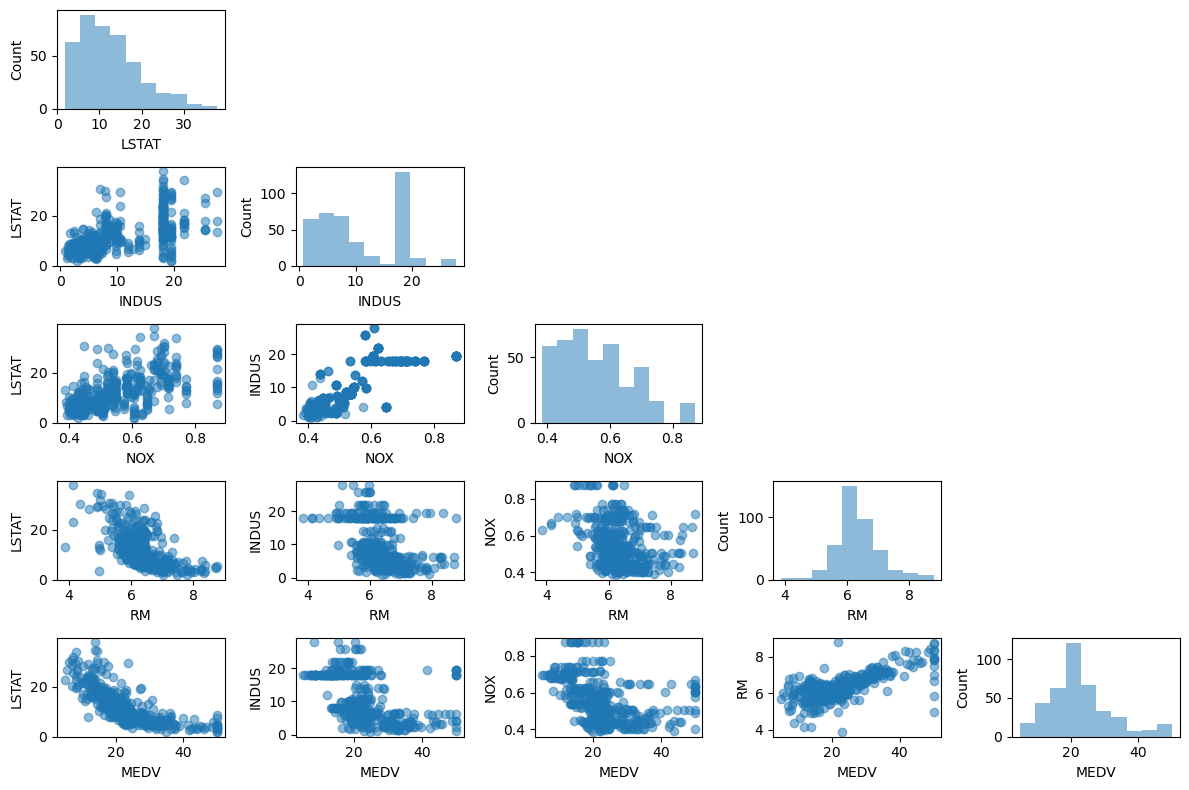

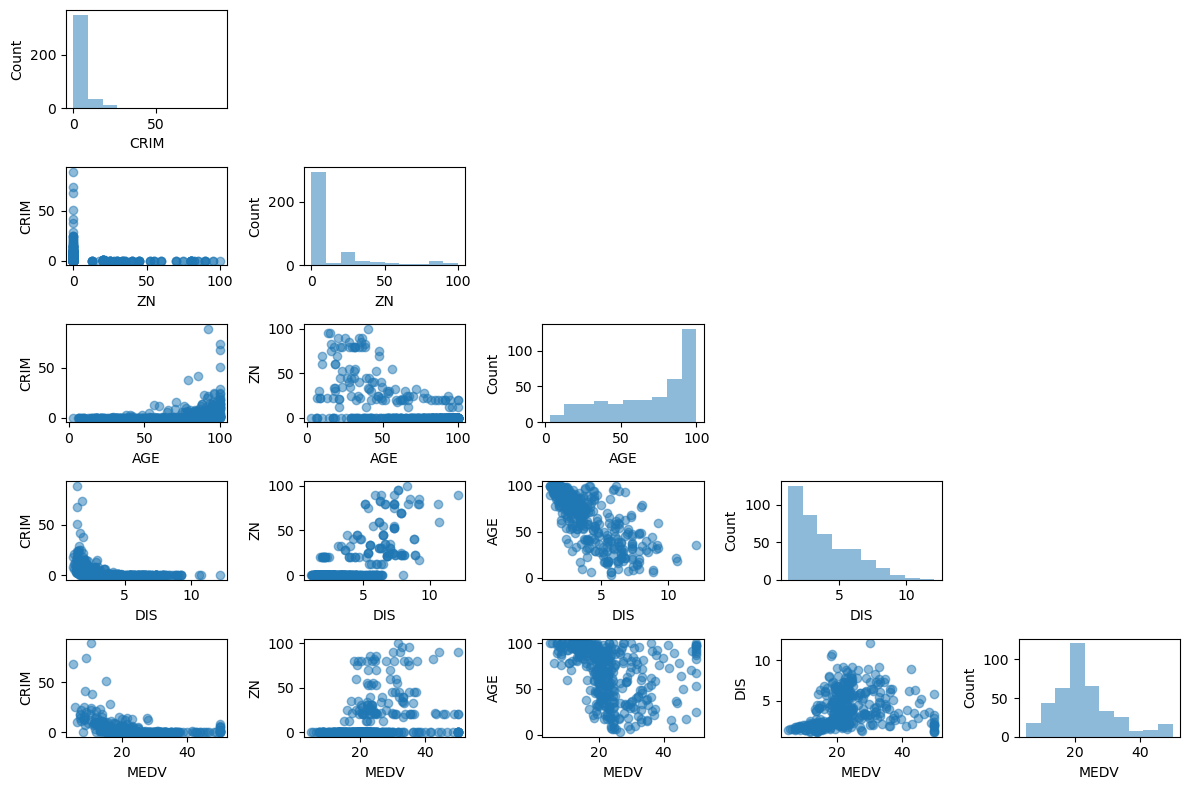

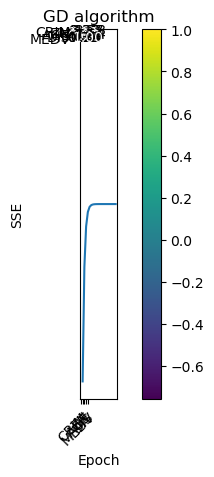

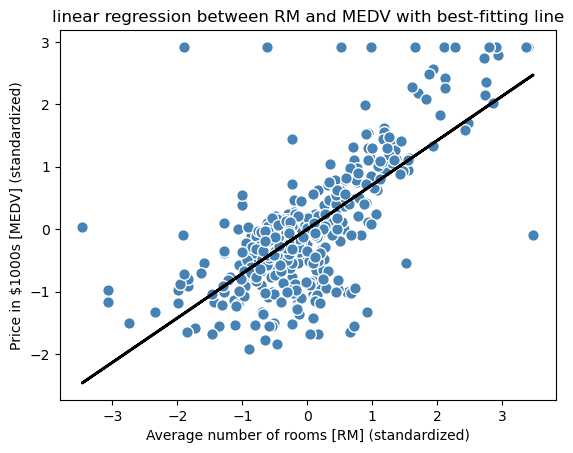

Price in $1000s: 19.844
Slope: 0.711
Intercept: 0.000
Slope: 9.348
Intercept: -36.246


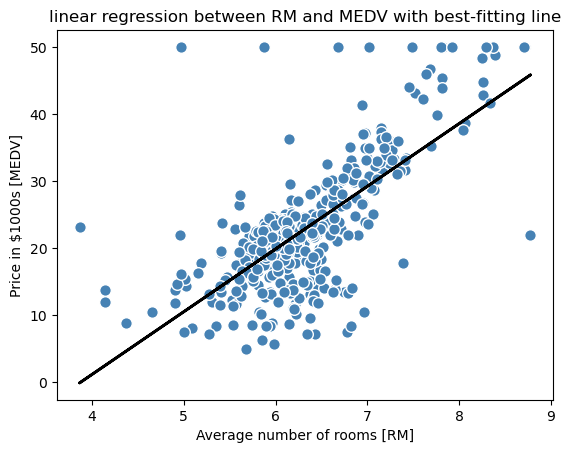

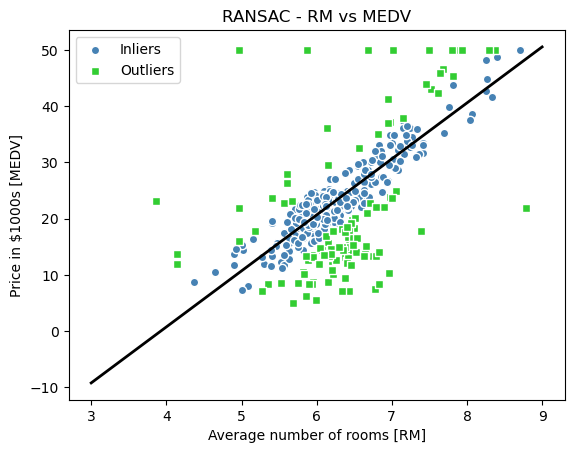

Slope: 9.964
Intercept: -39.115


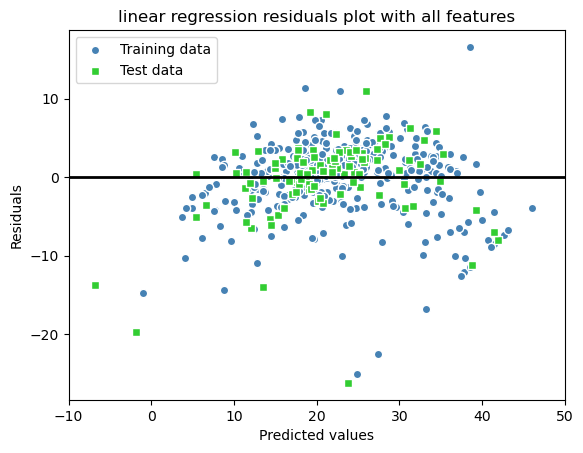

MSE train: 20.613, MSE test: 26.630
R^2 train: 0.763, test: 0.637
Slope: 2.774
Intercept: 24.220
MSE train: 20.793, MSE test: 26.827
R^2 train: 0.761, R^2 test: 0.634


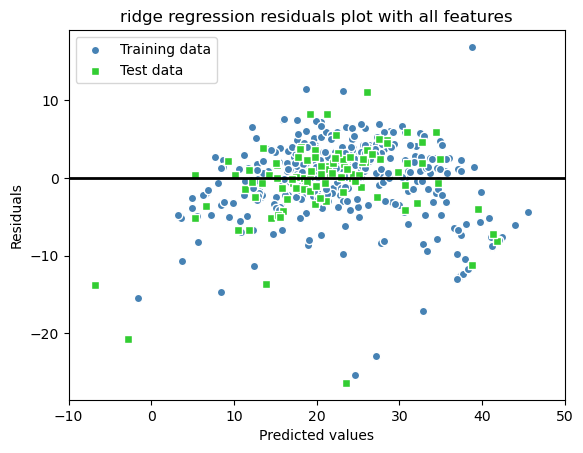

Slope: 0.000
Intercept: 34.936
MSE train: 26.417, MSE test: 24.409
R^2 train: 0.696, R^2 test: 0.667


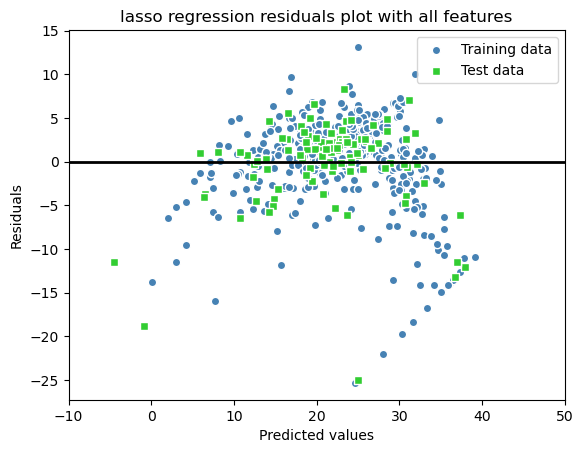

My name is Youshi Wang
My NetID is: youshiw2
I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 18:16:05 2023

@author: Jerry
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split

df=pd.read_csv('housing1.csv')  #the dataset with noise
df.columns
df.head()

from mlxtend.plotting import scatterplotmatrix
#%%
#relationship between each one of 5 features with scatterplots
#perform histogram EDA on 5 features' distribution
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
train_cols,test_cols=train_test_split(df[cols],test_size=0.2,random_state=42) #train test split
scatterplotmatrix(train_cols.values, figsize=(12, 8),
                  names=cols,alpha=0.5)
plt.tight_layout()
plt.show()


#try other features with MEDV
cols1=['CRIM','ZN','AGE','DIS','MEDV']
train_cols1,test_cols1=train_test_split(df[cols1],test_size=0.2,random_state=42) #train test split
scatterplotmatrix(train_cols1.values, figsize=(12, 8),
                  names=cols1,alpha=0.5)
plt.tight_layout()
plt.show()

#visualize correlation coefficient of each pair of features with heatmap
from mlxtend.plotting import heatmap
cm = np.corrcoef(train_cols1.values.T)
hm = heatmap(cm,row_names=cols1,column_names=cols1)
plt.show

#%%
#define a linear regression model using gradient descent algorithm
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)
#select explanatory variable and response variable to train GD
X=df['RM'].values
y=df['MEDV'].values
#perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#standardize explanatory and response variable for better convergence of GD algotithm
from sklearn.preprocessing import StandardScaler
sc_x=StandardScaler()
sc_y=StandardScaler()
X_std = sc_x.fit_transform(X_train.reshape(-1, 1))  #column values are in 1D array shape, must reshape to 2D array
y_std=sc_y.fit_transform(y_train[:,np.newaxis]).flatten()
lr=LinearRegressionGD()
lr.fit(X_std,y_std)

#visualize GD algorithm convergence
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.title('GD algorithm')
plt.show()

#define a function to visualize how well regression model fits training data
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.title('linear regression between RM and MEDV with best-fitting line')
plt.show()

#apply linear regression model to predict house price given number of rooms
num_rooms_std = sc_x.transform(np.array([[6.0]]))
price_std = lr.predict(num_rooms_std)
price_std_2d = price_std.reshape(1, -1) #reshape to 2D array
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std_2d)) #the output must be 'unstandardized'

#display gradiant
print('Slope: %.3f' % lr.w_[1])
#display y-intercept
print('Intercept: %.3f' % lr.w_[0])

#%%
#use linear regression model provided in sklearn, which fits with unstandardized values
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train.reshape(-1,1), y_train)
y_pred = slr.predict(X_train.reshape(-1,1))
#display coefficient
print('Slope: %.3f' % slr.coef_[0])
#display y-intercept
print('Intercept: %.3f' % slr.intercept_)

#plot scatterplot to visualize LinearRegression model fitting X_train and y_train
lin_regplot(X_train.reshape(-1,1), y_train, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.title('linear regression between RM and MEDV with best-fitting line')
plt.show()

#implement robust regression model using RANSAC algorithm to detect outliers
#maximum iterations, minimum number of training samples are passed to the algorithm
#computes absolute vertical distance
#tolerance for inlier set to 5.0 away from fitted line
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_error',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X_train.reshape(-1,1),y_train)

#visualize ransac-linear regression model to observe outliers
inlier_mask = ransac.inlier_mask_
outlier_mask =  np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X_train[inlier_mask], y_train[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X_train[outlier_mask], y_train[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.title('RANSAC - RM vs MEDV')
plt.show()
#display coefficient
print('Slope: %.3f' % ransac.estimator_.coef_[0])
#display y-intercept
print('Intercept: %.3f' % ransac.estimator_.intercept_)

#%%
#use all explanatory variables (all columns except MEDV) for response variable MEDV
#train_test_split all variables
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42)
#train a linear regression model with multiple features (multiple-regression model)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#evaluate the performance of the linear regression model with residuals plot
#2-D relationship plots are not available for models with multiple variables
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.title('linear regression residuals plot with all features')
plt.show()

#evaluate the performance of the linear regression model with mean squared error (MSE)
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, MSE test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

#evaluate linear regression model performance with R2:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

#%%
#fit ridge model to all features, with default alpha of 1.0
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)    #change alpha value to test different performance
ridge.fit(X_train, y_train)
y_train_pred=ridge.predict(X_train)
y_test_pred=ridge.predict(X_test)
#display slope and intercept of this model 
print('Slope: %.3f' % ridge.coef_[0])   
print('Intercept: %.3f' % ridge.intercept_)
#display MSE and R2 of this model
print('MSE train: %.3f, MSE test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, R^2 test: %.3f' %
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))
#plot residuals of this model
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.title('ridge regression residuals plot with all features')
plt.show()

#attempt to find the best alpha on training dataset from a range
from sklearn.model_selection import GridSearchCV
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_reg = Ridge()
param_grid = {'alpha': alpha_range}
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_['alpha']

#find the best alpha on test dataset
grid_search.fit(X_test, y_test)
grid_search.best_params_['alpha']

#%%
#fit ridge model to all features, with default alpha of 1.0
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred=lasso.predict(X_train)
y_test_pred=lasso.predict(X_test)
#display slope and intercept of this model 
print('Slope: %.3f' % lasso.coef_[0])   
print('Intercept: %.3f' % lasso.intercept_)
#display MSE and R2 of this model
print('MSE train: %.3f, MSE test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, R^2 test: %.3f' %
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))
#plot residuals of this model
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.title('lasso regression residuals plot with all features')
plt.show()

#attempt to find the best alpha on training dataset from a range
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
lasso_reg = Lasso()
param_grid = {'alpha': alpha_range}
grid_search = GridSearchCV(lasso_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_['alpha']

#find the best alpha on test dataset
grid_search.fit(X_test, y_test)
grid_search.best_params_['alpha']

#%%
print("My name is Youshi Wang")
print("My NetID is: youshiw2")
print("I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.")





In [4]:
%cd /Users/Jerry/Documents/GitHub/Youshi_Wang-s-repo/IE517_Spring2023_HW4

C:\Users\Jerry\Documents\GitHub\Youshi_Wang-s-repo\IE517_Spring2023_HW4
